## Traducción de Inglés a Sindarin

En este notebook vamos a entrenar los modelos Marian y T5 para que aprendan el lenguaje Sindarin. Para ellos, podemos

In [15]:
from huggingface_hub import login

token = ""
print("Hugging Face logging")
login(token)

Hugging Face logging


In [16]:
import torch
device_setup = "cuda" if torch.cuda.is_available() else "cpu"
print("Using: ", device_setup)

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

Using:  cpu


In [17]:
from libs.mts import T5MT, MarianMT
from libs.mts import load_pretrained_t5, load_pretrained_marian_mt

## Entrenamiento de un modelo desde 0



### Construcción de un dataset para el entrenamiento

Lo primero a realizar es preparar un conjunto de entrenamiento y otro de evaluación para la tarea de traducir de Inglés a Sindarin, para maximizar las posibilidades de obtener buenos resultados vamos a realizar un entrenamiento y evaluación con overfit. Para ello, se proporciona la función `build_datasets()`  presente en el paquete `libs.lotr_ds_builder`.

Prepare dos conjuntos de datos: `train_dataset` y `eval_dataset`. Pudiendo contener el segundo elementos del primero, en caso de obtener resultados demasiado buenos habría hacer dos conjuntos de datos disjuntos.

In [18]:
from libs.lotr_ds_builder import build_datasets
from datasets import Dataset

# DONE: Utilizar la función build_datasets() y generar un traing_dataset y test_dataset de Inglés a Sindarin
train, test = build_datasets()
train_dataset = train['Sindarin']
test_dataset = test['Sindarin']

# DONE: Cargar los datasets usando la clase Dataset
train_dataset = Dataset.from_dict(train_dataset)
eval_dataset = Dataset.from_dict(test_dataset)

# DONE: Mostrar la primera frase, la utilizaremos para probar los modelos
print(">", train_dataset['translation'][0])

{'Sindarin': 163, 'Adûnaic': 28, 'Black Speech': 26, 'Quenya': 45, 'Rohirric': 19}
{'Sindarin': 65, 'Rohirric': 18}
> {'en': 'Who brings to us this token of darkness?', 'fo': 'Man ammen toltha i dann hen morn?'}


## Entrenar un modelo MarianMT

In [19]:
from transformers import MarianMTModel, MarianTokenizer, MarianConfig

# Crear configuración para un modelo Marian en blanco
config = MarianConfig(
    vocab_size=32000,
    max_position_embeddings=512,
    encoder_layers=6,
    decoder_layers=6,
    encoder_attention_heads=8,
    decoder_attention_heads=8,
    d_model=512,
    d_ff=2048,
    dropout=0.1,
    pad_token_id=0,
    eos_token_id=1,
    bos_token_id=2,
)

# DONE: Crear el modelo MarianMT desde cero
marian_model_tmp = MarianMTModel(config)

# Cargar el tokenizador
marian_tokenizer_tmp = MarianTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-es")
marian_model_tmp.resize_token_embeddings(len(marian_tokenizer_tmp))

# Guardar el modelo
marian_model_tmp.save_pretrained("./models/trained-marian-en-sindarin")
marian_tokenizer_tmp.save_pretrained("./models/trained-marian-en-sindarin")

# Escribir una función para cargar el modelo y tokenizador
def load_trained_marian():
    marian_model = MarianMTModel.from_pretrained("./models/trained-marian-en-sindarin")
    marian_tokenizer = MarianTokenizer.from_pretrained("./models/trained-marian-en-sindarin")
    return marian_model, marian_tokenizer

In [20]:
from transformers import Trainer, TrainingArguments, DataCollatorForSeq2Seq

training_args = TrainingArguments(
    output_dir="./models/training/trained-marian-en-sindarin",
    eval_strategy="epoch",
    learning_rate=2e-4,
    per_device_train_batch_size=10,
    gradient_accumulation_steps=4,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_strategy="steps",
    logging_steps=100,
    logging_dir='./logs',
    report_to="none"
)

marian_model_trained, marian_tokenizer_trained = load_trained_marian()

def preprocess_function(examples):
    global marian_tokenizer_trained
    inputs_lang = [example['en'] for example in examples['translation']]
    targets_lang =  [example['fo'] for example in examples['translation']]

    model_inputs = marian_tokenizer_trained(inputs_lang, text_target=targets_lang, max_length=128, truncation=True, padding="max_length")
    return model_inputs

encoded_training_dataset = train_dataset.map(preprocess_function, batched=True)
encoded_eval_dataset = eval_dataset.map(preprocess_function, batched=True)

collator = DataCollatorForSeq2Seq(tokenizer=marian_tokenizer_trained, model=marian_model_trained)
trainer = Trainer(
    model=marian_model_trained,
    args=training_args,
    train_dataset=encoded_training_dataset,
    eval_dataset=encoded_eval_dataset,
    data_collator= collator
)

trainer.train()

marian_model_trained.save_pretrained("./models/trained-marian-en-sindarin")
marian_tokenizer_trained.save_pretrained("./models/trained-marian-en-sindarin")

Map:   0%|          | 0/163 [00:00<?, ? examples/s]

Map:   0%|          | 0/65 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
0,No log,10.505916
1,No log,9.920702
2,No log,9.376151
4,No log,8.371985
5,No log,8.045220
6,No log,7.790345
8,No log,7.495367
9,No log,7.480723


('./models/trained-marian-en-sindarin/tokenizer_config.json',
 './models/trained-marian-en-sindarin/special_tokens_map.json',
 './models/trained-marian-en-sindarin/vocab.json',
 './models/trained-marian-en-sindarin/added_tokens.json')

Una vez entrenado el modelo usar el siguiente código para comprobar como traduce una frase del dataset:

In [21]:
marian_model_trained = MarianMT(model_name="./models/trained-marian-en-sindarin", cache_dir="./models/trained-marian-en-sindarin")
text = "Who brings to us this token of darkness?"
translated_text = marian_model_trained.translate(text)
print(">Marian trained: ", translated_text)

>Marian trained:  ãùãÞnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn


## Entrenar un modelo T5
Siguiendo la explicación del notebook `mt_finetuned` entrene un modelo T5. Puede utilizar un modelo baseline y refinarlo o uno desde 0.


In [22]:
from transformers import T5ForConditionalGeneration, T5Tokenizer, T5Config

# Crear configuración para un modelo T5 en blanco
config = T5Config(
    vocab_size=32000,
    d_model=512,
    d_ff=2048,
    num_layers=6,
    num_heads=8,
    dropout_rate=0.1,
    pad_token_id=0,  # Token de padding
    eos_token_id=1,  # Token de fin de secuencia
    decoder_start_token_id=0,  # Token de inicio del decodificador
)

t5_model_trained = T5ForConditionalGeneration(config)

t5_tokenizer_trained = T5Tokenizer.from_pretrained("vgaraujov/t5-base-translation-en-es")

t5_model_trained.save_pretrained("./models/trained-t5-en-sindarin")
t5_tokenizer_trained.save_pretrained("./models/trained-t5-en-sindarin")

def load_t5():
    t5_model = T5ForConditionalGeneration.from_pretrained("./models/trained-t5-en-sindarin")
    t5_tokenizer = T5Tokenizer.from_pretrained("./models/trained-t5-en-sindarin")
    return t5_model, t5_tokenizer


Utilizando el primer modelo, generar una version refinada que esté entrenada con el dataset

In [23]:
from transformers import Trainer, TrainingArguments, DataCollatorForSeq2Seq

training_args = TrainingArguments(
    output_dir="./models/training/trained-t5-en-sindarin",
    eval_strategy="epoch",
    learning_rate=2e-4,
    per_device_train_batch_size=10,
    gradient_accumulation_steps=4,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_strategy="steps",
    logging_steps=100,
    logging_dir='./logs',
    report_to="none"
)


t5_model_trained, t5_tokenizer_trained = load_t5()

def preprocess_function(examples):
    global t5_tokenizer_trained
    inputs_lang = [example['en'] for example in examples['translation']]
    targets_lang =  [example['fo'] for example in examples['translation']]

    model_inputs = t5_tokenizer_trained(inputs_lang, text_target=targets_lang, max_length=128, truncation=True, padding="max_length")
    return model_inputs

encoded_training_dataset = train_dataset.map(preprocess_function, batched=True)
encoded_eval_dataset = eval_dataset.map(preprocess_function, batched=True)

collator = DataCollatorForSeq2Seq(tokenizer=t5_tokenizer_trained, model=t5_model_trained)
trainer = Trainer(
    model=t5_model_trained,
    args=training_args,
    train_dataset=encoded_training_dataset,
    eval_dataset=encoded_eval_dataset,
    data_collator= collator
)

trainer.train()

t5_model_trained.save_pretrained("./models/trained-t5-en-sindarin")
t5_tokenizer_trained.save_pretrained("./models/trained-t5-en-sindarin")

Map:   0%|          | 0/163 [00:00<?, ? examples/s]

Map:   0%|          | 0/65 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
0,No log,1.016089
1,No log,0.755466
2,No log,0.663211
4,No log,0.604478
5,No log,0.588803
6,No log,0.568696
8,No log,0.541742
9,No log,0.540030


('./models/trained-t5-en-sindarin/tokenizer_config.json',
 './models/trained-t5-en-sindarin/special_tokens_map.json',
 './models/trained-t5-en-sindarin/spiece.model',
 './models/trained-t5-en-sindarin/added_tokens.json')

Una vez entrenado el modelo usar el siguiente código para comprobar como traduce una frase del dataset:

In [24]:
t5_model_trained = T5MT(model_name="./models/trained-t5-en-sindarin", cache_dir="./models/trained-t5-en-sindarin")
text = "Who brings to us this token of darkness?"
translated_text = t5_model_trained.translate(text)
print(">t5 trained: ", translated_text)

>t5 trained:  Annnnnnnnnnnnnnnnnnnnnnnnnnnnnnn.


## Comparar todos los modelos usando las metricas BLEU, METEOR y ROUGE

In [25]:
import evaluate


expected_results = [ [row['fo']] for row in eval_dataset['translation']]
inputs = [row['en'] for row in eval_dataset['translation']]


t5_trained_results = t5_model_trained.translate_batch(inputs)
marianmt_trained_results = marian_model_trained.translate_batch(inputs)

print("Expected Results:", expected_results)
print("T5 Translations:", t5_trained_results)
print("Marian Translations:", marianmt_trained_results)

bleu_metric = evaluate.load("bleu")
meteor_metric = evaluate.load("meteor")
rouge_metric = evaluate.load("rouge")

bleu_t5_trained = bleu_metric.compute(predictions=t5_trained_results, references=expected_results)
meteor_t5_trained = meteor_metric.compute(predictions=t5_trained_results, references=expected_results)
rouge_t5_trained = rouge_metric.compute(predictions=t5_trained_results, references=expected_results)

bleu_marian_trained = bleu_metric.compute(predictions=marianmt_trained_results, references=expected_results)
meteor_marian_trained = meteor_metric.compute(predictions=marianmt_trained_results, references=expected_results)
rouge_marian_trained = rouge_metric.compute(predictions=marianmt_trained_results, references=expected_results)


Expected Results: [['Hiro hyn hîdh ab ’wanath.'], ['Aragorn, nad no ennas!'], ['Man cenich?'], ['Man le trasta, Brego?'], ['Man cenich?'], ['Ú i vethed'], ['nâ i onnad.'], ['Minlû pedich nin'], ['i aur hen telitha.'], ['Ú i vethednâ i onnad.'], ['Boe bedich go Frodo.'], ['Dolen i vâd o nin.'], ['Si peliannen i vâd na dail lîn.'], ['Si boe ú-dhannathach.'], ['Ae ú-esteliach nad'], ['estelio han'], ['estelio ammen.'], ['Estelio han.'], ['Estelio han.'], ['Estelio veleth.'], ['Nach gwannatha sin?'], ['Ma nathach hi gwannathach or minuial archened?'], ['Ú-ethelithon.'], ['Estelio guru lîn ne dagor.'], ['Ethelithach.'], ['Ú-bedin o gurth ne dagor.'], ['O man pedich?'], ['Edra le men, men na guil edwen'], ['haer o auth a nîr a naeth.'], ['Tollen, i lû.'], ['I chair gwannar na Valannor. Si bado, no círar.'], ['Ah im, ú-’erin veleth lîn?'], ['Gerich veleth nîn, ada.'], ['I amar prestar aen.'], ['Han mathon ne nen.'], ['Han mathon ne chae.'], ['A han noston ned ’wilith.'], ['Mae carnen, Brego, 

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/andreacimmino/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/andreacimmino/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/andreacimmino/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


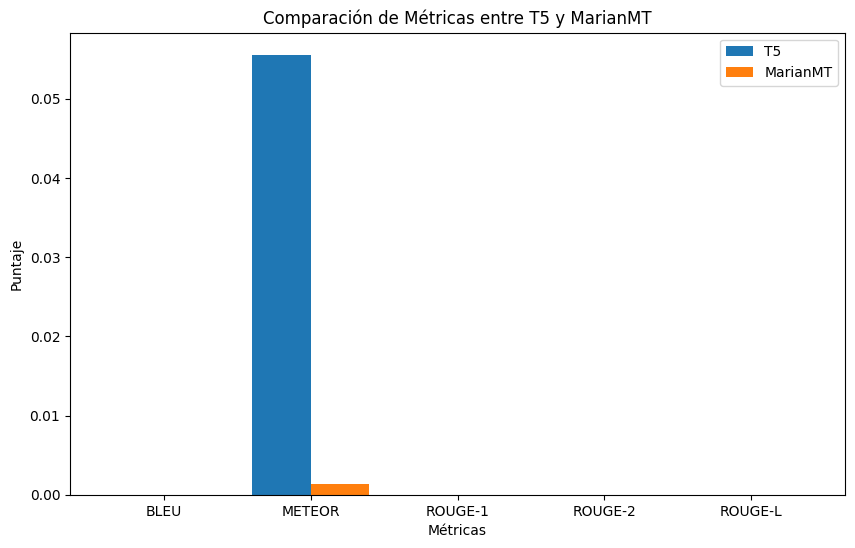

In [26]:
import matplotlib.pyplot as plt

# Sustituye estos valores por los resultados reales
scores_t5 = {
    "BLEU": bleu_t5_trained['bleu'],
    "METEOR": meteor_t5_trained["meteor"],
    "ROUGE-1": rouge_t5_trained["rouge1"],
    "ROUGE-2": rouge_t5_trained["rouge2"],
    "ROUGE-L": rouge_t5_trained["rougeL"]
}

scores_marian = {
    "BLEU": bleu_marian_trained["bleu"],
    "METEOR": meteor_marian_trained["meteor"],
    "ROUGE-1": rouge_marian_trained["rouge1"],
    "ROUGE-2": rouge_marian_trained["rouge2"],
    "ROUGE-L": rouge_marian_trained["rougeL"],
}

# Crear gráfico
labels = list(scores_t5.keys())
t5_values = list(scores_t5.values())
marian_values = list(scores_marian.values())

x = range(len(labels))

plt.figure(figsize=(10, 6))
plt.bar(x, t5_values, width=0.4, label="T5", align="center")
plt.bar([i + 0.4 for i in x], marian_values, width=0.4, label="MarianMT", align="center")

# Configurar etiquetas y leyenda
plt.xticks([i + 0.2 for i in x], labels)
plt.xlabel("Métricas")
plt.ylabel("Puntaje")
plt.title("Comparación de Métricas entre T5 y MarianMT")
plt.legend()